In [52]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 1
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
#import matplotlib.pyplot as plt

import os
cwd = os.getcwd()

path = Path(cwd + '/data/')
path.ls()

[PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks'), PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImages.txt'), PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImagesToDuplicate.txt'), PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/NoBoneImages.txt'), PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images'), PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/codes.txt'), PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/valid.txt')]
[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks'), PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImages.txt'), PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImagesToDuplicate.txt'), PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/NoBoneImages.txt'), PosixPath('/home/thor/notebooks/se

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.51
fastprogress  : 0.1.20
torch         : 1.0.1
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7301 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.15.0-1041-azure-x86_64-with-debian-stretch-sid
distro        : #45-Ubuntu SMP Fri Mar 15 14:41:00 UTC 2019
conda env     : py35
python        : /data/anaconda/envs/py35/bin/python
sys.path      : /opt/caffe/python
/opt/caffe2/build
/data/home/thor/notebooks/sensorx-contaminant-detection
/data/anaconda/envs/py35/lib/python36.zip
/data/anaconda/envs/py35/lib/python3.6
/data/anaconda/envs/py35/lib/python3.6/lib-dynload

/data/anaconda/envs/py35/lib/python3.6/site-packages
/data/anaconda/envs/py35/lib/python3.6/site-packages/IPython/extensions
/data/home/thor/.ipython
```

Please make sure to include opening/closing ``` when you paste into foru

In [3]:
path_lbl = path/'masks'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_48_-1CL_0.0481968kg.tif')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_48_-1CL_0.0481968kg.tif')]

In [6]:
# Select 10% validation images and handpicked meatl images
metal = ['MAGNA_3_86.3626CL_3.97524kg.tif',
'MAGNA_20_78.9422CL_0.960883kg.tif', 
'MAGNA_48_-1CL_0.437527kg.tif', 
'MAGNA_49_-1CL_0.440395kg.tif', 
'MAGNA_50_-1CL_0.317512kg.tif', 
'MAGNA_51_-1CL_0.453667kg.tif', 
'MAGNA_52_-1CL_0.360127kg.tif', 
'MAGNA_53_-1CL_0.446551kg.tif', 
'MAGNA_54_-1CL_0.441927kg.tif', 
'MAGNA_55_-1CL_0.454831kg.tif', 
'MAGNA_56_-1CL_0.446517kg.tif', 
'MAGNA_57_-1CL_0.442111kg.tif', 
'MAGNA_58_-1CL_0.453068kg.tif', 
'MAGNA_59_-1CL_0.328768kg.tif', 
'MAGNA_60_-1CL_0.439103kg.tif', 
'MAGNA_61_83.7706CL_3.88116kg.tif']

no_metal_names = np.array([img.name for img in fnames])
for metal_img in metal:
    no_metal_names = no_metal_names[no_metal_names != metal_img]

validation_count = len(no_metal_names) // 10 # 10% of the non-metal images
validation_files = np.random.choice(no_metal_names, size=validation_count, replace=False)
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tif', 'MAGNA_61_83.7706CL_3.88116kg.tif',
                             'MAGNA_54_-1CL_0.441927kg.tif']
validation_files = np.append(validation_files, validation_metal)

outF = open("data/valid.txt", "w")
output = map(lambda x: x + '\n', validation_files)
outF.writelines(output)
outF.close()

def incorrect_contam(input, target):
    '''Computes the average number of incorrect number of contaminants in labeled image'''
#     print(input.size())
#     print(target.size())
    
    target = target.squeeze(1)
    input = input.argmax(dim=1)
             
#     print(input)
#     print(target)
#     print(input.size())
#     print(target.size())
#     print(target[0], target[1])
#     print(np.unique(target[0]), np.unique(target[1]))
    mean_incorrect = []
    for i in range(input.size()[0]):
        input_contaminants = np.argwhere(input[i] < 1)[0]       # <1, 0 and 1 are belt and meat
        target_contaminants = np.argwhere(target[i] < 1)[0]

#         print(input_contaminants, input_contaminants)

        count_incorrect = np.abs(len(input_contaminants) - len(target_contaminants))
        mean_incorrect.append(count_incorrect.mean())
        
#         print(count_incorrect, mean_incorrect)
    
    mean_incorrect = np.mean(mean_incorrect)
    ret = torch.Tensor(1)
    ret[0] = mean_incorrect
    
#     print(mean_incorrect, ret)
    
    # raise Exception('Stuff')
    
    return ret

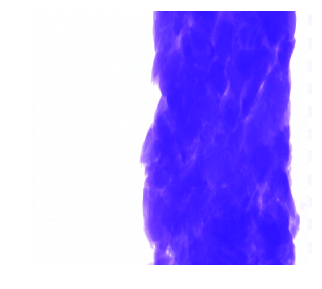

In [7]:
## Data

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
#plt.show()

In [8]:
img_f.parent.parent

PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data')

[700 768] tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


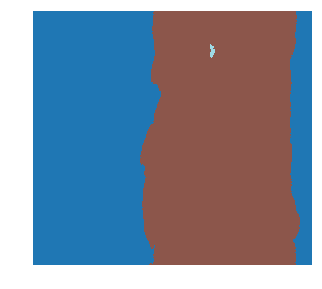

In [9]:
def get_y_fn(x):
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])
print(src_size, mask.data)

In [10]:
## Datasets
bs,size = 8,src_size//2
transforms = ([RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True)],
              [RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-180.0, 180.0)}, p=1.0, resolved={}, do_run=True, is_random=True)])

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file(str(path) + '/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(transforms, size=size, tfm_y=True) # tfm_y=True to apply the same transform to the mask
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [11]:
print(data.train_ds)
print()
print(data.test_ds)
print()
print(data.valid_ds)

LabelList (3859 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /home/thor/notebooks/sensorx-contaminant-detection/data/images

None

LabelList (430 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /home/thor/notebooks/sensorx-contaminant-detection/data/images


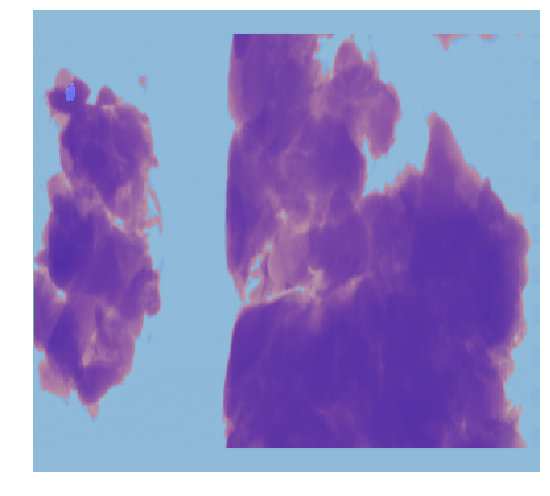

In [12]:
data.show_batch(1, figsize=(10,7))

In [13]:
def error_measure(input, target):
    target = target.squeeze(1)
    mask_isVoid = target != name2id['Belt']
    mask_isBone = target == name2id['Bone']
    mask_ismetal = target == name2id['Metal']
    
    error = (input.argmax(dim=1)[mask_isVoid]!=target[mask_isVoid]).float().mean()
    boneError = input.argmax(dim=1)[mask_isBone]!=target[mask_isBone]
    metalError = input.argmax(dim=1)[mask_ismetal]!=target[mask_ismetal]
    if len(boneError) != 0:
        error += boneError.float().mean()
    if len(metalError) != 0:
        error += 4*metalError.float().mean()
    
    return error
    

In [14]:
# weights = torch.FloatTensor([0., 1., 10., 100.]) # ['Belt', 'Meat', 'Bone', 'Metal'])
# def forward(y_hat, y)->Rank0Tensor:  # This custom loss did not work with the backpropagation
#     y_hat = y_hat.argmax(dim=1)
#     y = y.squeeze(1)
    
#     costs = weights[y] * torch.log(y_hat.float() + 1e-16) # epsilon=1e-45
#     cost = costs.sum().double()
#     return cost

weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
def customLossFunction(input, target): # Works
    target = target.squeeze(1)
    return F.nll_loss(torch.log_softmax(input, 1), target, weight, reduction='mean')
    
# Works
class CustomLoss():
    "Weighted Cross Entropy Loss."
    
    def __init__(self):
        self.weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
        self.func = nn.CrossEntropyLoss(self.weight)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        target = target.squeeze(1)        
        return self.func.__call__(input, target, **kwargs)

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [16]:
def IoU(input:Tensor, targs:Tensor)->Rank0Tensor:
    return dice(input, targs, iou=True)

In [17]:
wd=1e-2

In [18]:
# The image is reduced by half (data.batch_stats), and has 3 chanels by default (the other two are set to 1)
learn = unet_learner(data, models.resnet34, wd=wd)#, loss_func=nn.CrossEntropyLoss(weight))#, loss_func=CustomLoss()) #customLossFunction

learn.crit = MixedLoss(10.0, 5.0)
learn.metrics=[dice, IoU, incorrect_contam]

In [19]:
x, y = data.one_batch(DatasetType.Train, True, True)
data.one_batch

<bound method DataBunch.one_batch of ImageDataBunch;

Train: LabelList (3859 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /home/thor/notebooks/sensorx-contaminant-detection/data/images;

Valid: LabelList (430 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /home/thor/notebooks/sensorx-contaminant-detection/data/images;

Test: None>

In [20]:
learn.loss_func, data.loss_func

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [21]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


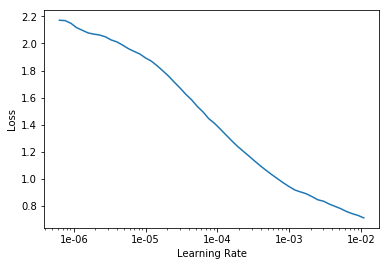

In [22]:
learn.recorder.plot()

In [23]:
lr=1e-4

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,IoU,incorrect_contam,time
0,0.036232,0.048220,0.991118,0.982550,1030.044189,18:09
1,0.021816,0.024761,0.999332,0.998813,132.369766,17:56
2,0.016018,0.020377,1.001080,1.003398,386.265106,17:58
3,0.014239,0.017464,1.003332,1.008474,365.923248,18:04
4,0.014359,0.014935,1.002871,1.006330,128.146515,18:04
5,0.011772,0.013679,1.006321,1.015043,106.455811,18:08
6,0.009974,0.014304,1.008666,1.019714,128.158142,18:11
7,0.010471,0.012987,1.007622,1.017915,171.244186,18:09
8,0.008826,0.011805,1.006993,1.016369,113.983719,18:11
9,0.007954,0.011566,1.008080,1.018451,113.767441,18:12


In [25]:
learn.save('stage-1-big')

In [26]:
learn.load('stage-1-big');

In [27]:
learn.unfreeze()

In [28]:
lrs = slice(1e-6,lr/10)

In [29]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,dice,IoU,incorrect_contam,time
0,0.007809,0.011412,1.008262,1.019167,117.923256,18:48
1,0.008023,0.011571,1.008185,1.018993,102.202324,18:49
2,0.007461,0.011308,1.008312,1.018974,109.474419,18:50
3,0.007633,0.011640,1.007846,1.018215,118.495346,18:50
4,0.007369,0.011233,1.008228,1.018928,117.758141,18:50
5,0.007371,0.011182,1.008428,1.019199,128.676743,18:50
6,0.007152,0.011143,1.008652,1.019548,104.930229,18:50
7,0.007039,0.011290,1.008731,1.019896,116.869766,18:51
8,0.007146,0.011774,1.008223,1.018691,121.618607,18:51
9,0.007403,0.011673,1.008312,1.018826,115.599998,18:51


In [30]:
learn.save('stage-2-big')

In [31]:
learn.load('stage-2-big');

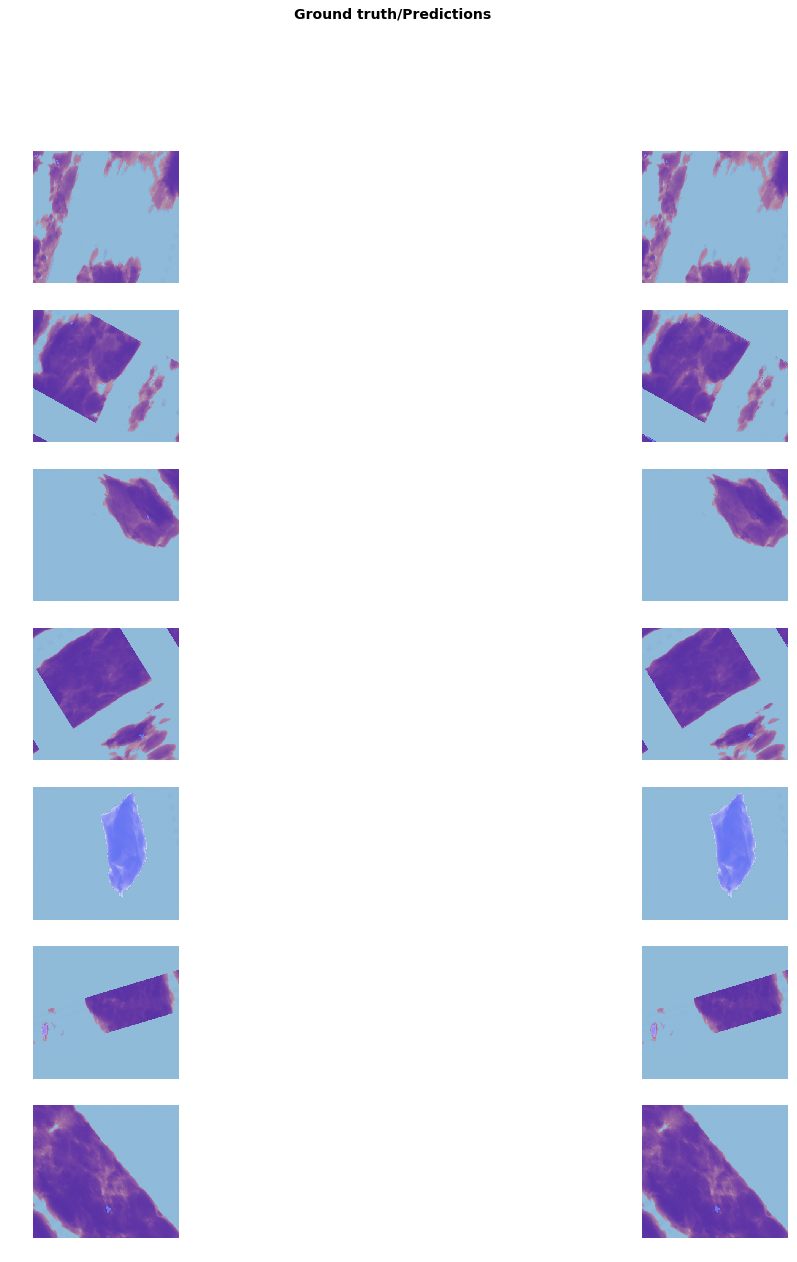

In [32]:
learn.show_results(rows=learn.data.batch_size-1, figsize=(20,20)) # This shows incorrect predictions?

In [33]:
preds,y = learn.get_preds()

In [34]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth / Predictions
########################
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 57, Metal: 0
Prediction   -> Bone: 55, Metal: 0


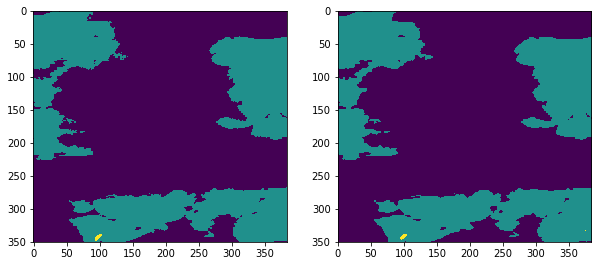

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 102, Metal: 0
Prediction   -> Bone: 87, Metal: 0


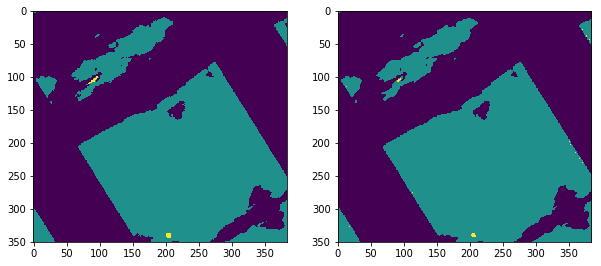

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 50, Metal: 0
Prediction   -> Bone: 48, Metal: 0


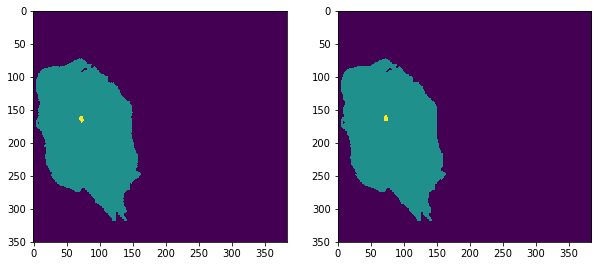

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0
Prediction   -> Bone: 207, Metal: 0


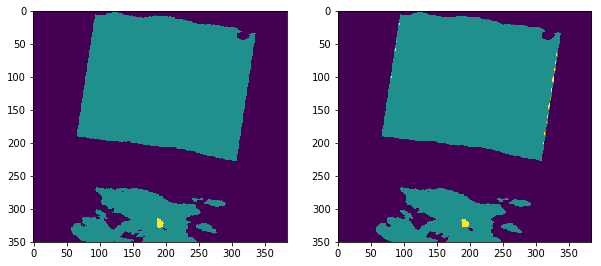

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 3
Prediction   -> Bone: 1, Metal: 0


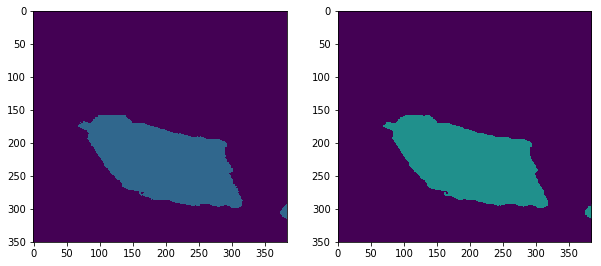

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 365, Metal: 0
Prediction   -> Bone: 403, Metal: 0


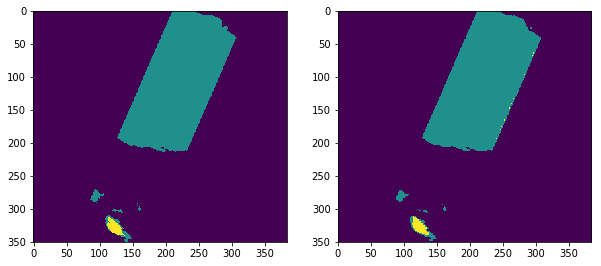

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 148, Metal: 0
Prediction   -> Bone: 157, Metal: 0


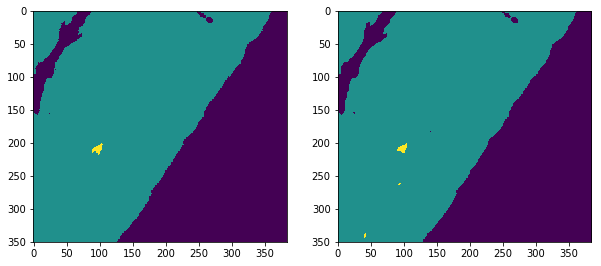

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 100, Metal: 0
Prediction   -> Bone: 108, Metal: 0


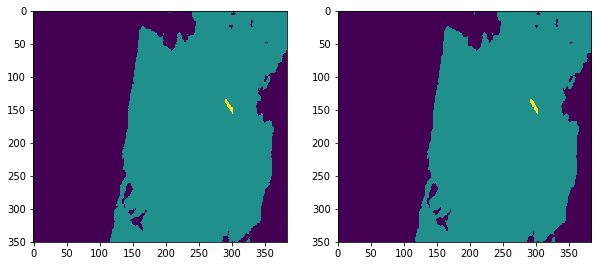

In [35]:
y = torch.squeeze(y)
print("########################")
print("Ground truth / Predictions")
print("########################")
for i in range(8): #learn.data.batch_size-1):
    prediction = preds.argmax(dim=1)[i]
    print("There is {} / Found {}".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}".format(len(y[i][y[i] == 2]), len(y[i][y[i] == 3])))
    print("Prediction   -> Bone: {}, Metal: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3])))
    plt.show()
    

In [50]:
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tif', 'MAGNA_61_83.7706CL_3.88116kg.tif',
                             'MAGNA_54_-1CL_0.441927kg.tif']
for name in validation_metal:
#     print(path, name)
    name = path / ('images/' + name)
    print(name)
#     help(learn.predict)
#     ground_truth = open_image(name.replace('images', 'masks'))
    prediction = learn.predict(open_image(name))
    prediction = prediction[1]
    print(ground_truth)
    print(np.unique(prediction))
    
#     print("There is {} / Found {}".format(getContanimentInfo(ground_truth), getContanimentInfo(prediction)))
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(1, 2, 1)
#     plt.imshow(ground_truth)
#     fig.add_subplot(1, 2, 2)
#     plt.imshow(prediction)
#     print("Pixel count")
#     print("Ground truth -> Bone: {}, Metal: {}".format(len(ground_truth[ground_truth == 2]), len(ground_truth[ground_truth == 3])))
#     print("Prediction   -> Bone: {}, Metal: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3])))
#     plt.show()
#     break

/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_56_-1CL_0.446517kg.tif
Image (3, 700, 768)
[0 1]
/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_61_83.7706CL_3.88116kg.tif
Image (3, 700, 768)
[0 1 2]
/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_54_-1CL_0.441927kg.tif
Image (3, 700, 768)
[0 1]
